# Case Study 4.3: Products Recommender

Instructor: Devavrat Shah

Activity Type: Optional 

Case Study Description: Building your own recommendation system for products on an e-commerce website, like the examples discussed for Amazon.com. Make new Product Recommendations

Why this Case Study? By following some simple steps you can develop your own version of a recommendation engine which forms the basis of several e-commerce websites like Amazon.com. This will help you develop an appreciation for the sorts of innovations that underpin the rise and ubiquity of online retailers and e-commerce portals. You can apply these tools to new retail ventures of your choice.

Self-Help Documentation: In this document, we walk through some helpful tips to get you started with building your own Recommendation engine based on the case studies discussed in the Recommendation systems module. In this tutorial, we provide examples and some pseudo-code for the following programming environments: R, Python. 

Download Self-Help Documentation

Time Required: The time required to do this activity varies depending on your experience in the required programming background. We suggest planning somewhere between 1 & 3 hours. Remember, this is an optional activity for participants looking for hands-on experience.

#### Reference Articles:

http://jmcauley.ucsd.edu/data/amazon/

https://towardsdatascience.com/product-recommender-using-amazon-review-dataset-e69d479d81dd

https://www.kaggle.com/saurav9786/recommender-system-using-amazon-reviews

https://github.com/mandeep147/Amazon-Product-Recommender-System/blob/master/Recommender%20System/Recommender%20System.ipynb

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib
import math as mt
from scipy.sparse import csc_matrix


import seaborn as sns
import squarify
from sklearn import metrics


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Getting Data

In [2]:
raw_data = pd.read_csv('ratings_Electronics.csv', names=['user','item','rating','timestamp'])

In [3]:
raw_data['date'] = pd.to_datetime(raw_data.timestamp, unit='s')

In [4]:
raw_data['month_year'] = raw_data['date'].apply(lambda x: x.strftime('%Y-%m'))

In [5]:
raw_data.head()

user        item  rating   timestamp       date month_year
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200 2013-04-13    2013-04
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800 2012-07-01    2012-07
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600 2013-04-29    2013-04
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200 2013-07-22    2013-07
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200 2012-04-18    2012-04

## Exploring Data

In [6]:
#Check for missing values
print('Number of missing values across columns: \n', raw_data.isnull().sum())

Number of missing values across columns: 
 user          0
item          0
rating        0
timestamp     0
date          0
month_year    0
dtype: int64


In [7]:
raw_data.describe()

rating     timestamp
count  7.824482e+06  7.824482e+06
mean   4.012337e+00  1.338178e+09
std    1.380910e+00  6.900426e+07
min    1.000000e+00  9.127296e+08
25%    3.000000e+00  1.315354e+09
50%    5.000000e+00  1.361059e+09
75%    5.000000e+00  1.386115e+09
max    5.000000e+00  1.406074e+09

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user        object        
 1   item        object        
 2   rating      float64       
 3   timestamp   int64         
 4   date        datetime64[ns]
 5   month_year  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 358.2+ MB


In [9]:
users_raw_data = raw_data.user.nunique()
items_raw_data = raw_data.item.nunique()
sparsity_raw_data = (len(raw_data) / (items_raw_data * users_raw_data)) * 100.00
print (users_raw_data, " users")
print (items_raw_data, " items")
print ('Sparsity is: ', sparsity_raw_data)



4201696  users
476002  items
Sparsity is:  0.0003912210290338533


In [10]:
#reducing sparsity where products having at least 50 ratings
data = raw_data.groupby("item").filter(lambda x:x['rating'].count() >=50)

In [11]:
users = data.user.nunique()
items = data.item.nunique()
print (users, " users")
print (items, " items")
sparsity = (len(data) / (items * users)) * 100.00

print ('Sparsity is: ', sparsity)

3225223  users
26226  items
Sparsity is:  0.006353765044727139


In [12]:
#Now back to the histogram
print ("generating the histogram")
data.rating.value_counts().sort_index().plot.bar(alpha=0.6);

generating the histogram


In [13]:
#checking the percentual by rating on the dataset
print ("Generating percentuals:")
(data.rating.value_counts().sort_index() / len(data.rating)).map(lambda n: '{:.2%}'.format(n))

Generating percentuals:


1.0    10.64%
2.0     5.57%
3.0     7.73%
4.0    18.93%
5.0    57.13%
Name: rating, dtype: object

### 10 Popular Products

In [14]:
popular_products = data.groupby(['item']).agg({'rating': 'sum'}).reset_index()
popular_products = popular_products.sort_values(['rating', 'item'], ascending = [0,1]).head(10)

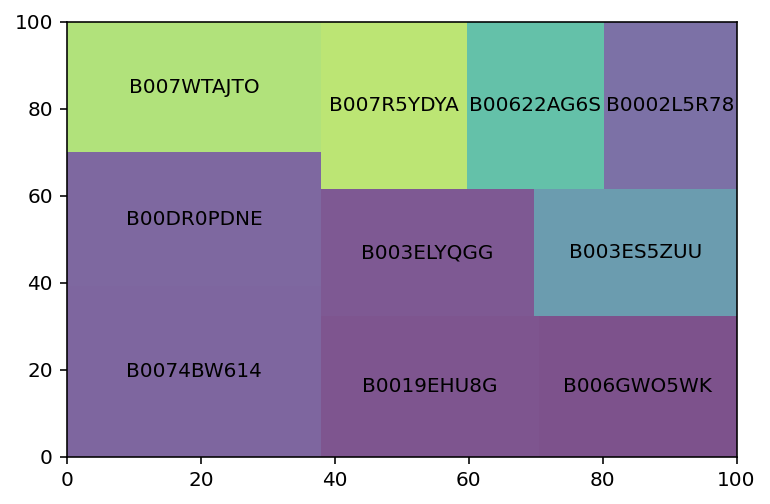

<Figure size 1440x1080 with 0 Axes>

In [15]:
volume = popular_products.rating
labels = popular_products.item

squarify.plot(sizes=volume, label=labels,
              alpha=0.7)

plt.figure(figsize=(20, 15))

plt.show()

In [16]:
popular_products['percentage'] = popular_products['rating'].div(popular_products['rating'].sum())*100
popular_products = popular_products.sort_values(['rating', 'item'], ascending = [0,1]).head(10)

In [17]:
popular_products

item   rating  percentage
19245  B0074BW614  81943.0   14.846064
25032  B00DR0PDNE  64681.0   11.718613
20325  B007WTAJTO  62697.0   11.359161
6593   B0019EHU8G  58409.0   10.582280
18581  B006GWO5WK  52751.0    9.557189
11856  B003ELYQGG  51028.0    9.245024
11875  B003ES5ZUU  48346.0    8.759111
20101  B007R5YDYA  46473.0    8.419769
18241  B00622AG6S  43419.0    7.866459
1751   B0002L5R78  42204.0    7.646331

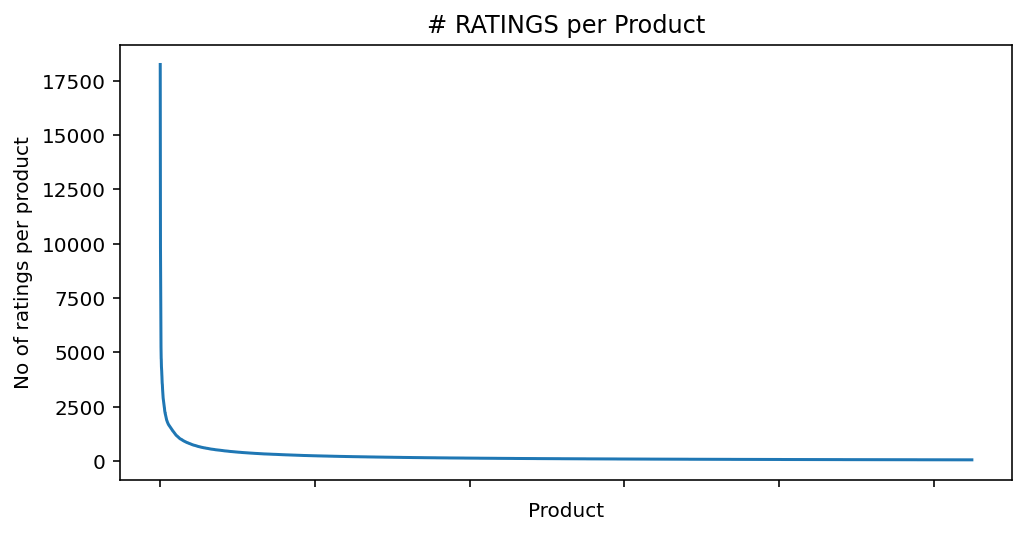

In [18]:
no_of_ratings_per_product = data.groupby(by='item')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [19]:
ratings_mean_count = pd.DataFrame(data.groupby('item')['rating'].mean())

ratings_mean_count['rating_counts'] = pd.DataFrame(data.groupby('item')['rating'].count())

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50);

In [20]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<Figure size 576x432 with 0 Axes>

## Recommending

In [21]:
# Splitting the data
from sklearn.model_selection import train_test_split

# Splitinto training and testing sets
X_train, X_test = train_test_split(data, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# recommended_popularity = X_train.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
# train_popular_songs = recommended_popularity.sort_values(['listen_count', 'song'], ascending = [0,1]).head(10)

## Collaberative filtering (Item-Item recommedation

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We are going to use collaborative filtering (CF) approach. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.Collaborative filtering has two sub-categories that are generally called memory based and model-based approaches.

In [22]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [23]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
newData = Dataset.load_from_df(data[['user', 'item', 'rating']] ,reader)

In [24]:
#Splitting the dataset
trainset, testset = train_test_split(newData, test_size=0.2,random_state=10)

In [25]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [26]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [27]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3345


1.3345287465693558

## Model-based collaborative filtering system

These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [28]:
subset = data.head(200000)

ratings_matrix = subset.pivot_table(values='rating', index='user', columns='item', fill_value=0)
ratings_matrix.head()

item                   0972683275  1400501466  1400501520  1400501776  \
user                                                                    
A00124802J36AVPT3779A           0           0           0           0   
A00570163ATHRHPDG3GKN           0           0           0           0   
A00625243BI8W1SSZNLMD           0           0           0           0   
A0072193KFP6LUHKEXLT            0           0           0           0   
A00988692Q9ZDJUD8BQSM           0           0           0           0   

item                   1400532620  1400532655  140053271X  1400532736  \
user                                                                    
A00124802J36AVPT3779A           0           0           0           0   
A00570163ATHRHPDG3GKN           0           0           0           0   
A00625243BI8W1SSZNLMD           0           0           0           0   
A0072193KFP6LUHKEXLT            0           0           0           0   
A00988692Q9ZDJUD8BQSM           0           0           0           0   

item                   1400599997  1400698987  ...  B0000APONO  B0000AQI9E  \
user                                           ...                           
A00124802J36AVPT3779A           0           0  ...           0           0   
A00570163ATHRHPDG3GKN           0           0  ...           0           0   
A00625243BI8W1SSZNLMD           0           0  ...           0           0   
A0072193KFP6LUHKEXLT            0           0  ...           0           0   
A00988692Q9ZDJUD8BQSM           0           0  ...           0           0   

item                   B0000AQIFW  B0000AQIFY  B0000AQIFZ  B0000AQNX2  \
user                                                                    
A00124802J36AVPT3779A           0           0           0           0   
A00570163ATHRHPDG3GKN           0           0           0           0   
A00625243BI8W1SSZNLMD           0           0           0           0   
A0072193KFP6LUHKEXLT            0           0           0           0   
A00988692Q9ZDJUD8BQSM           0           0           0           0   

item                   B0000AQR8F  B0000AR8Z1  B0000ATNH3  B0000AZ0OP  
user                                                                   
A00124802J36AVPT3779A           0           0           0           0  
A00570163ATHRHPDG3GKN           0           0           0           0  
A00625243BI8W1SSZNLMD           0           0           0           0  
A0072193KFP6LUHKEXLT            0           0           0           0  
A00988692Q9ZDJUD8BQSM           0           0           0           0  

[5 rows x 1144 columns]

In [29]:
ratings_matrix.shape

(178279, 1144)

In [30]:
X = ratings_matrix.T
X.head()

user        A00124802J36AVPT3779A  A00570163ATHRHPDG3GKN  \
item                                                       
0972683275                      0                      0   
1400501466                      0                      0   
1400501520                      0                      0   
1400501776                      0                      0   
1400532620                      0                      0   

user        A00625243BI8W1SSZNLMD  A0072193KFP6LUHKEXLT  \
item                                                      
0972683275                      0                     0   
1400501466                      0                     0   
1400501520                      0                     0   
1400501776                      0                     0   
1400532620                      0                     0   

user        A00988692Q9ZDJUD8BQSM  A00995931BE16NG4F52QC  \
item                                                       
0972683275                      0                      0   
1400501466                      0                      0   
1400501520                      0                      0   
1400501776                      0                      0   
1400532620                      0                      0   

user        A01035471LBTPFWCOKAU2  A014623426J5CM7M12MBW  \
item                                                       
0972683275                      0                      0   
1400501466                      0                      0   
1400501520                      0                      0   
1400501776                      0                      0   
1400532620                      0                      0   

user        A01771021FA6LVUILJVPD  A01817022GAUTPHMU63NJ  ...  AZZP8BC9WE0N8  \
item                                                      ...                  
0972683275                      0                      0  ...              0   
1400501466                      0                      0  ...              0   
1400501520                      0                      0  ...              0   
1400501776                      0                      0  ...              0   
1400532620                      0                      0  ...              0   

user        AZZQFCVCFE8HL  AZZSCU0QYNQQ6  AZZST8OYL5P4Q  AZZUBI2MEAHI9  \
item                                                                     
0972683275              0              0              0              0   
1400501466              0              0              0              0   
1400501520              0              0              0              0   
1400501776              0              0              0              0   
1400532620              0              0              0              0   

user        AZZUDVKC0E2XU  AZZUQYE2C1LNI  AZZX23UGJGKTT  AZZYWDOD33FFE  \
item                                                                     
0972683275              0              0              0              0   
1400501466              0              0              0              0   
1400501520              0              0              0              0   
1400501776              0              0              0              0   
1400532620              0              0              0              0   

user        AZZZEWADNFNUM  
item                       
0972683275              0  
1400501466              0  
1400501520              0  
1400501776              0  
1400532620              0  

[5 rows x 178279 columns]

In [31]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(1144, 10)

In [33]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(1144, 1144)

In [38]:
X.index[80]

'B00000K4KH'

In [39]:
#Index # of product ID purchased by customer

i = "B00000K4KH"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

80

In [40]:
#Correlation for all items with the item purchased by this customer based on 
#items rated by other customers people who bought the same product

correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(1144,)

In [42]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['B000001OM4',
 'B00000J061',
 'B00000JSGF',
 'B00000JYLO',
 'B00000K2YR',
 'B00001P4XH',
 'B00001P4ZH',
 'B00001P505',
 'B00001W0DD',
 'B00002CEX9',
 'B00004LMEC',
 'B00004SB99',
 'B00004SY4H',
 'B00004TEN2',
 'B00004UE2R',
 'B00004VUGJ',
 'B00004XO1V',
 'B00004YBVE',
 'B00004Z0BO',
 'B00004Z6KW',
 'B00004Z6Q6',
 'B00004Z7G9',
 'B000051SD1',
 'B000051WW9']